In [6]:
# logging utility

import time
from datetime import datetime

LOG_FILE = "latent_experiment_log_190226.txt"

def log_message(message: str):
    stamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{stamp}] {message}"
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(line + "\n")



In [7]:
# --------------------------------------------------------------
# Latent-Space Face Impersonation (Reduced-Compute Variant)
# MSc Dissertation - Stella Williams
# Inversion-free latent target synthesis experiment
# Multi-run evaluation
# This run is to get the plot working from file 2_latent_impersonation_stylegan-refactor_NO_INVERSION_Loop2. 
# --------------------------------------------------------------




In [8]:
import os
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1


In [9]:
"Cell 2: Device, FaceNet setup"


# --------------------------------------------------------------
# Device configuration
# --------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# --------------------------------------------------------------
# FaceNet embedding model (verification system)
# --------------------------------------------------------------

facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)
# --------------------------------------------------------------
# Preprocessing for FaceNet (160x160 input requirement)
# --------------------------------------------------------------
to_facenet = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

def load_image(path):
    return Image.open(path).convert("RGB")

def img_to_tensor(img):
    return to_facenet(img).unsqueeze(0).to(device)

@torch.no_grad()
def facenet_embed(img_tensor):
    emb = facenet(img_tensor)
    return nn.functional.normalize(emb, p=2, dim=1)

def cosine(a, b):
    return (a * b).sum(dim=1)



Using device: cpu


In [10]:
# --------------------------------------------------------------
# Load pretrained StyleGAN2-ADA generator
# --------------------------------------------------------------
import sys
sys.path.append("/Users/stel/Documents/Dissertation/msc-biometric-security-clean/stylegan2-ada-pytorch")



import pickle

STYLEGAN_REPO = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/stylegan2-ada-pytorch"
STYLEGAN_PKL  = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Models/stylegan2-ffhq.pkl"

if STYLEGAN_REPO not in sys.path:
    sys.path.append(STYLEGAN_REPO)

with open(STYLEGAN_PKL, "rb") as f:
    G = pickle.load(f)["G_ema"].to(device).eval()

print("Loaded StyleGAN2")
print("z_dim:", G.z_dim)





Loaded StyleGAN2
z_dim: 512


In [11]:
# --------------------------------------------------------------
# Generator wrapper
# Converts single w latent into w+ internally
# --------------------------------------------------------------

def synth_from_w_single(w):
    """
    Accepts either:
    - w shape [1, w_dim]
    - w shape [1, num_ws, w_dim] (w+)

    Returns image in [0,1]
    """

    if w.ndim == 2:
        # w is [1, w_dim] → broadcast to w+
        w_plus = w.unsqueeze(1).repeat(1, G.synthesis.num_ws, 1)
    elif w.ndim == 3:
        # Already w+
        w_plus = w
    else:
        raise ValueError(f"Unexpected latent shape: {w.shape}")

    img = G.synthesis(w_plus, noise_mode="const")
    img = (img + 1) / 2
    return img.clamp(0, 1)



In [12]:
# --------------------------------------------------------------
# Load target identity (impersonation objective)
# --------------------------------------------------------------

TARGET_A_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw/Lenny_Kravitz/Lenny_Kravitz_0001.jpg"
TARGET_B_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw/Patricia_Clarkson/Patricia_Clarkson_0001.jpg"

targetA_img = load_image(TARGET_A_PATH)
targetB_img = load_image(TARGET_B_PATH)

targetA_t = img_to_tensor(targetA_img)
targetB_t = img_to_tensor(targetB_img)

with torch.no_grad():
    e_target = facenet_embed(targetA_t)
    e_nontarget = facenet_embed(targetB_t)

print("Target embedding norm:", e_target.norm().item())

# print("Initial w shape:", w.shape)
#inspecting the shape, it is likely [1, 1, w_dim], or [1, num_ws, w_dim] - with the latter meaning
#we are alreadz in w+ space and the wrapper must not broadcast again. in my previous version, no loop,
#i initialised w differently, mapping for from a random latent or mapping. dimensions changed.
print("Target embedding ready.")

Target embedding norm: 1.0
Target embedding ready.


In [13]:
log_message("--------------------------------------------------")
log_message(f"Experiment started: {datetime.now()}")
log_message("Reduced-compute latent impersonation batch")
log_message("--------------------------------------------------")

In [15]:
# --------------------------------------------------------------
# Multi-Run Latent Impersonation Experiment
# --------------------------------------------------------------

NUM_RUNS = 2
MAX_STEPS = 5
TARGET_SIM = 0.85
LR = 0.03

log_message("--------------------------------------------------")
log_message("Multi-run 80-step max latent impersonation test version 2")
log_message("--------------------------------------------------")


results = []
best_example = None

print("\nRunning latent impersonation batch...\n")
print("NUM_RUNS =", NUM_RUNS)

print("Sanity check — target cosine before optimisation:")
with torch.no_grad():
    z_test = torch.randn(1, G.z_dim, device=device)
    w_test = G.mapping(z_test, None)
    img_test = synth_from_w_single(w_test)
    img_test_160 = nn.functional.interpolate(img_test, (160,160))
    emb_test = facenet_embed(img_test_160)
    print("Initial random cosine to target:", cosine(emb_test, e_target).item())


for run in range(NUM_RUNS):

    print(f"\n=== Run {run+1}/{NUM_RUNS} ===")
    log_message(f"\n=== Run {run+1}/{NUM_RUNS} ===")

    torch.manual_seed(run)

    # Random z initialisation
    z = torch.randn(1, G.z_dim, device=device)
    with torch.no_grad():
        w = G.mapping(z, None)

    w = w.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([w], lr=LR)

    start_time = time.time()
    success = False

    pbar = tqdm(range(MAX_STEPS), desc=f"Run {run+1}", leave=True)

    for step in pbar:

        img = synth_from_w_single(w)
        img_160 = nn.functional.interpolate(
            img, (160,160),
            mode="bilinear",
            align_corners=False
        )

        emb = facenet(img_160)
        emb = nn.functional.normalize(emb, dim=1)

        sim_target = cosine(emb, e_target)
        sim_nontarget = cosine(emb, e_nontarget)

        loss = 1 - sim_target.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({
            "cos_target": f"{sim_target.item():.4f}",
            "cos_non_target": f"{sim_nontarget.item():.4f}"
        })


        if step % 10 == 0:
            msg = (
                f"Run {run+1} | Step {step} | "
                f"cos_target={sim_target.item():.4f} | "
                f"cos_non_target={sim_nontarget.item():.4f}"
            )
            print(msg)
            log_message(msg)

        if sim_target.item() >= TARGET_SIM:
            success = True
            best_example = img.detach().cpu()
            break

    runtime = time.time() - start_time

    final_target = sim_target.item()
    final_non_target = sim_nontarget.item()

    summary = (
        f"Run {run+1} COMPLETE | "
        f"Success={success} | "
        f"Steps={step+1} | "
        f"Final_target={final_target:.4f} | "
        f"Final_non_target={final_non_target:.4f} | "
        f"Runtime_sec={runtime:.2f}"
    )

    print(summary)
    log_message(summary)

    results.append({
        "success": success,
        "steps": step + 1,
        "final_sim_target": final_target,
        "final_sim_non_target": final_non_target,
        "runtime_sec": runtime
    })


Running latent impersonation batch...

NUM_RUNS = 5
Sanity check — target cosine before optimisation:
Initial random cosine to target: 0.1210743635892868

=== Run 1/5 ===


Run 1:   1%| | 1/80 [06:58<9:10:54, 418.42s/it, cos_target=-0.0902, cos_non_targ

Run 1 | Step 0 | cos_target=-0.0902 | cos_non_target=0.1679


Run 1:  14%|▏| 11/80 [1:08:47<7:02:10, 367.11s/it, cos_target=0.6569, cos_non_ta

Run 1 | Step 10 | cos_target=0.6569 | cos_non_target=-0.1122


Run 1:  26%|▎| 21/80 [2:09:35<5:58:53, 364.97s/it, cos_target=0.7978, cos_non_ta

Run 1 | Step 20 | cos_target=0.7978 | cos_non_target=-0.1612


Run 1:  32%|▎| 26/80 [2:46:07<5:45:02, 383.38s/it, cos_target=0.8623, cos_non_ta


Run 1 COMPLETE | Success=True | Steps=27 | Final_target=0.8623 | Final_non_target=-0.1923 | Runtime_sec=9968.03

=== Run 2/5 ===


Run 2:   1%| | 1/80 [06:03<7:58:21, 363.31s/it, cos_target=0.1665, cos_non_targe

Run 2 | Step 0 | cos_target=0.1665 | cos_non_target=-0.1398


Run 2:  14%|▏| 11/80 [1:07:24<6:59:50, 365.09s/it, cos_target=0.8226, cos_non_ta

Run 2 | Step 10 | cos_target=0.8226 | cos_non_target=-0.0370


Run 2:  18%|▏| 14/80 [1:31:38<7:12:02, 392.77s/it, cos_target=0.8625, cos_non_ta


Run 2 COMPLETE | Success=True | Steps=15 | Final_target=0.8625 | Final_non_target=-0.1119 | Runtime_sec=5498.81

=== Run 3/5 ===


Run 3:   1%| | 1/80 [06:01<7:55:34, 361.19s/it, cos_target=0.1056, cos_non_targe

Run 3 | Step 0 | cos_target=0.1056 | cos_non_target=0.2319


Run 3:  14%|▏| 11/80 [1:06:31<6:57:10, 362.75s/it, cos_target=0.7151, cos_non_ta

Run 3 | Step 10 | cos_target=0.7151 | cos_non_target=0.0300


Run 3:  25%|▎| 20/80 [2:07:02<6:21:07, 381.13s/it, cos_target=0.8637, cos_non_ta


Run 3 | Step 20 | cos_target=0.8637 | cos_non_target=-0.0786
Run 3 COMPLETE | Success=True | Steps=21 | Final_target=0.8637 | Final_non_target=-0.0786 | Runtime_sec=7622.61

=== Run 4/5 ===


Run 4:   1%| | 1/80 [06:01<7:56:25, 361.84s/it, cos_target=0.0600, cos_non_targe

Run 4 | Step 0 | cos_target=0.0600 | cos_non_target=-0.0147


Run 4:  14%|▏| 11/80 [1:06:25<6:57:14, 362.81s/it, cos_target=0.8444, cos_non_ta

Run 4 | Step 10 | cos_target=0.8444 | cos_non_target=-0.0746


Run 4:  14%|▏| 11/80 [1:12:28<7:34:39, 395.35s/it, cos_target=0.8625, cos_non_ta


Run 4 COMPLETE | Success=True | Steps=12 | Final_target=0.8625 | Final_non_target=-0.0949 | Runtime_sec=4348.83

=== Run 5/5 ===


Run 5:   1%| | 1/80 [06:02<7:57:09, 362.40s/it, cos_target=0.3125, cos_non_targe

Run 5 | Step 0 | cos_target=0.3125 | cos_non_target=-0.2477


Run 5:  14%|▏| 11/80 [1:06:30<6:57:26, 363.00s/it, cos_target=0.8485, cos_non_ta

Run 5 | Step 10 | cos_target=0.8485 | cos_non_target=-0.0829


Run 5:  14%|▏| 11/80 [1:12:31<7:34:54, 395.57s/it, cos_target=0.8619, cos_non_ta

Run 5 COMPLETE | Success=True | Steps=12 | Final_target=0.8619 | Final_non_target=-0.0828 | Runtime_sec=4351.22


In [16]:
print("\n==============================")
print("Batch Summary")
print("==============================")

if len(results) == 0:
    print("No runs completed.")
else:
    successes = [r for r in results if r["success"]]
    success_rate = len(successes) / len(results) * 100

    print(f"Total runs completed: {len(results)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successes) > 0:
        mean_steps = np.mean([r["steps"] for r in successes])
        mean_target = np.mean([r["final_sim_target"] for r in successes])
    else:
        mean_steps = 0
        mean_target = 0

    mean_non_target = np.mean([r["final_sim_non_target"] for r in results])
    mean_runtime = np.mean([r["runtime_sec"] for r in results]) / 60

    print(f"Mean steps (successful only): {mean_steps:.2f}")
    print(f"Mean final cosine (target): {mean_target:.4f}")
    print(f"Mean cosine (non-target): {mean_non_target:.4f}")
    print(f"Mean runtime: {mean_runtime:.2f} minutes")



Batch Summary
Total runs completed: 5
Success rate: 100.0%
Mean steps (successful only): 17.40
Mean final cosine (target): 0.8626
Mean cosine (non-target): -0.1121
Mean runtime: 105.97 minutes


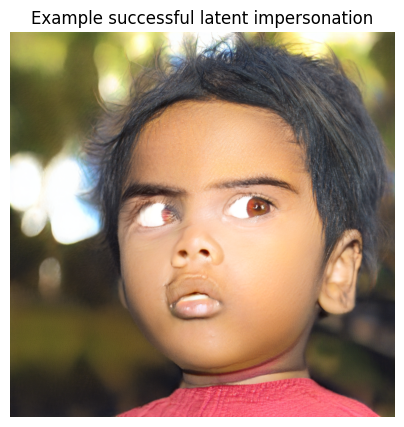

In [17]:
if best_example is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(best_example.squeeze().permute(1,2,0))
    plt.title("Example successful latent impersonation")
    plt.axis("off")
    plt.show()
else:
    print("No successful run to visualise.")
